In [72]:
pip install pandas numpy yfinance tensorflow alpaca-trade-api scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [73]:
pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [74]:
import yfinance as yf
import pandas as pd

# Fetch historical data for Nasdaq Composite
ticker = '^IXIC'
data = yf.download(ticker, start='2010-01-01', end='2024-01-01')

# Display the data
print(data.head())

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2010-01-04  2294.409912  2311.149902  2294.409912  2308.419922  2308.419922   
2010-01-05  2307.270020  2313.729980  2295.620117  2308.709961  2308.709961   
2010-01-06  2307.709961  2314.070068  2295.679932  2301.090088  2301.090088   
2010-01-07  2298.090088  2301.300049  2285.219971  2300.050049  2300.050049   
2010-01-08  2292.239990  2317.600098  2290.610107  2317.169922  2317.169922   

                Volume  
Date                    
2010-01-04  1931380000  
2010-01-05  2367860000  
2010-01-06  2253340000  
2010-01-07  2270050000  
2010-01-08  2145390000  


In [75]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Feature selection and scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(seq_length, len(data)):
        sequences.append(data[i-seq_length:i])
        labels.append(data[i])
    return np.array(sequences), np.array(labels)

seq_length = 60  # You can adjust this value
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Define the model
model = Sequential()

# First LSTM layer with Dropout regularization
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Second LSTM layer with Dropout regularization
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Third LSTM layer without return_sequences
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# First Dense layer with L2 regularization
model.add(Dense(units=50, activation='relu', kernel_regularizer=l2(0.001)))

# Second Dense layer with L2 regularization
model.add(Dense(units=25, activation='relu', kernel_regularizer=l2(0.001)))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='Nadam', loss='mean_squared_error')

/Users/nishanth/virtualenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [77]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate reduction on plateau to fine-tune the model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

# Train the model with callbacks
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early_stopping, reduce_lr])

Epoch 1/50


KeyboardInterrupt: 

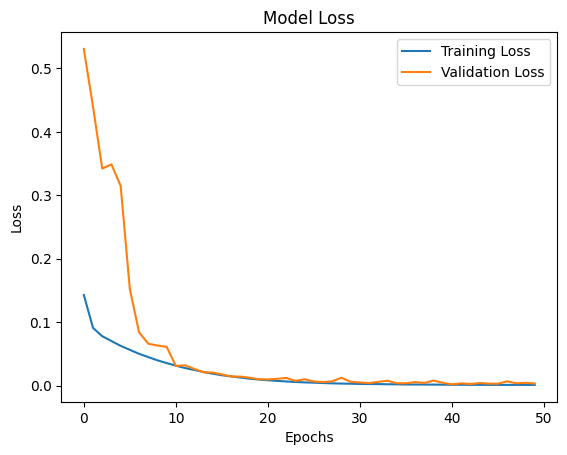

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable storing the training process results

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
RMSE: 23.529446248196837
MAE: 397.3545386904762
R-squared: 0.8803446950531065
MAPE: 3.052716202730836%


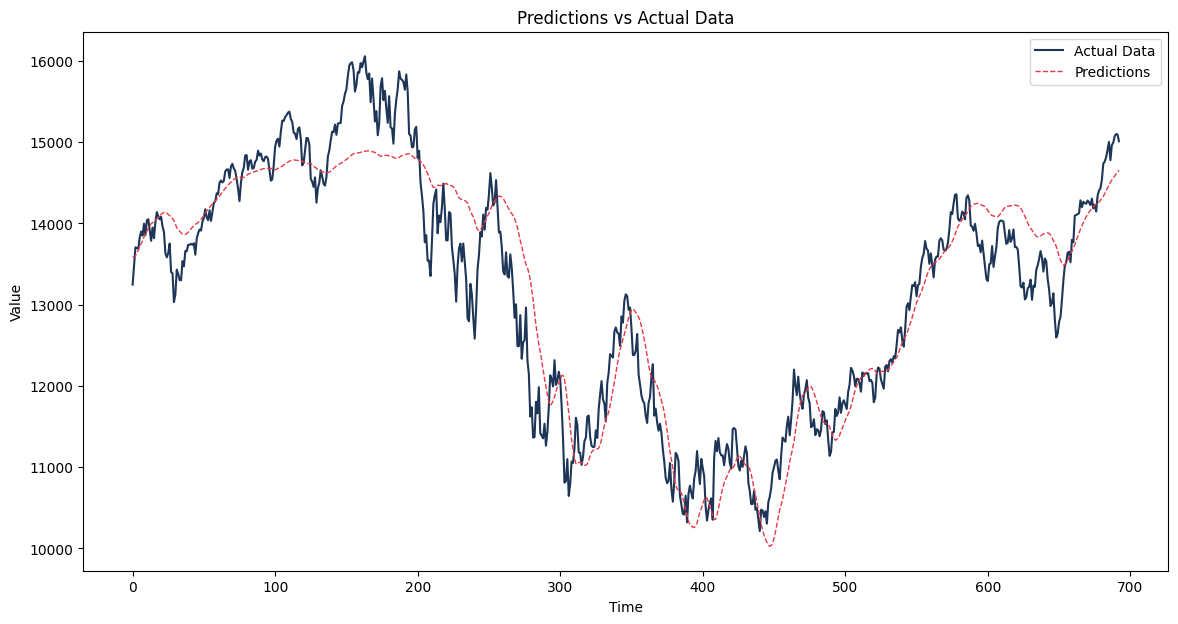

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Assuming you have already trained your model and have X_test, y_test, and scaler

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and y_test to original scale
predictions = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(np.mean(predictions - scaler.inverse_transform(y_test.reshape(-1, 1)))**2)
print(f'RMSE: {rmse}')

mae = mean_absolute_error(y_test_inverse, predictions)
print(f'MAE: {mae}')

r2 = r2_score(y_test_inverse, predictions)
print(f'R-squared: {r2}')

mape = np.mean(np.abs((y_test_inverse - predictions) / y_test_inverse)) * 100
print(f'MAPE: {mape}%')


# Plotting
plt.figure(figsize=(14, 7))
plt.plot(y_test_inverse, label='Actual Data', color='#1D3557')
plt.plot(predictions, label='Predictions', color='#E63946', linewidth='1', linestyle='--')
plt.title('Predictions vs Actual Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [88]:
from alpaca.trading.client import TradingClient
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.trading.requests import MarketOrderRequest
from alpaca.data import StockHistoricalDataClient, TimeFrame
from alpaca.data.requests import StockQuotesRequest, StockBarsRequest

API_KEY = "PKMJ1HTG418D5V1R4X8Q"
SECRET_KEY = "nL7szcUdyuIzLOthwVwb1eZsr9v8YP5IP5Bq1KqB"

quantity = 1
ticker = "QQQ"

api = TradingClient(API_KEY, SECRET_KEY)
data_client = StockHistoricalDataClient(API_KEY, SECRET_KEY)


print(ap.get_account().account_number)
print(ap.get_account().buying_power)

market_order_data = MarketOrderRequest(
    symbol=ticker,
    qty=quantity,
    side=OrderSide.BUY,
    time_in_force=TimeInForce.DAY
)

#market_order = api.submit_order(market_order_data)
#print(market_order)


def trade():
    # Fetch the latest market data
    #market_data = api.get_stock_bars(ticker, '1Min', limit=seq_length)
    market_data = data_client.get_stock_bars(request_params).df.tz_convert('America/New_York', level=1)

    # Preprocess the data
    close_prices = np.array([bar.c for bar in market_data])
    scaled_data = scaler.transform(close_prices.reshape(-1, 1))

    # Create the input sequence for prediction
    X_live = np.array([scaled_data])

    # Predict
    prediction = model.predict(X_live)
    predicted_price = scaler.inverse_transform(prediction)[0][0]

    # Get the last close price
    last_close = close_prices[-1]

    # Trading logic: Simple example
    if predicted_price > last_close:
        market_order = api.submit_order(market_order_data)
    #elif predicted_price < last_close:
        #place_order(ticker, qty=1, side='sell')

# Example of how to run the trading bot continuously
import time

while True:
    trade()
    time.sleep(60)  # Trade every minute

PA327VAFKYP7
199788.65


NameError: name 'request_params' is not defined

In [ ]:
import alpaca_trade_api as tradeapi

# Alpaca API credentials
API_KEY = 'PK07I82E0EXJ6V6J0BLA'
SECRET_KEY = 'dbWfrNsj8JJSd0gu80yjFSvioNNm7mfb6MbBAHYY'
BASE_URL = 'https://paper-api.alpaca.markets/v2'

#api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')

ticker = 'QQQ'
# Function to place an order
def place_order(symbol, qty, side):
    try:
        api.submit_order(
            symbol=symbol,
            qty=qty,
            side=side,
            type='market',
            time_in_force='gtc'
        )
        print(f"Order placed: {side} {qty} shares of {symbol}")
    except Exception as e:
        print(f"Error placing order: {e}")

# Live trading logic (pseudo-code, adapt to your strategy)
def trade():
    # Fetch the latest market data
    market_data = api.get_bars(ticker, '1Min', limit=seq_length)

    # Preprocess the data
    close_prices = np.array([bar.c for bar in market_data])
    scaled_data = scaler.transform(close_prices.reshape(-1, 1))

    # Create the input sequence for prediction
    X_live = np.array([scaled_data])

    # Predict
    prediction = model.predict(X_live)
    predicted_price = scaler.inverse_transform(prediction)[0][0]

    # Get the last close price
    last_close = close_prices[-1]

    # Trading logic: Simple example
    if predicted_price > last_close:
        place_order(ticker, qty=1, side='buy')
    elif predicted_price < last_close:
        place_order(ticker, qty=1, side='sell')

# Example of how to run the trading bot continuously
import time

while True:
    trade()
    time.sleep(60)  # Trade every minute


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Error placing order: 404 Client Error: Not Found for url: https://paper-api.alpaca.markets/v2/v2/orders


KeyboardInterrupt: 

In [97]:
from alpaca.trading.client import TradingClient
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.trading.requests import MarketOrderRequest
from alpaca.data import StockHistoricalDataClient, TimeFrame
from alpaca.data.requests import StockQuotesRequest, StockBarsRequest

API_KEY = "PKMJ1HTG418D5V1R4X8Q"
SECRET_KEY = "nL7szcUdyuIzLOthwVwb1eZsr9v8YP5IP5Bq1KqB"

quantity = 1
ticker = "QQQ"

api = TradingClient(API_KEY, SECRET_KEY)
data_client = StockHistoricalDataClient(API_KEY, SECRET_KEY)


print(ap.get_account().account_number)
print(ap.get_account().buying_power)

market_order_data = MarketOrderRequest(
    symbol=ticker,
    qty=quantity,
    side=OrderSide.BUY,
    time_in_force=TimeInForce.DAY
)

#market_order = api.submit_order(market_order_data)
#print(market_order)

# It's generally best to explicitly provide an end time but will default to 'now' if not
request_params = StockBarsRequest(
    symbol_or_symbols=ticker,
    timeframe=TimeFrame.Day,
    start=start_time
    )

bars_df = data_client.get_stock_bars(request_params).df.tz_convert('America/New_York', level=1)


PA327VAFKYP7
199790.86


In [101]:
from alpaca.trading.client import TradingClient
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.stream import TradingStream
#import config

client = TradingClient(API_KEY, SECRET_KEY)
#account = dict(client.get_account())
#for k,v in account.items():
    #print(f"{k:30}{v}")

order_details = MarketOrderRequest(
    symbol= "QQQ",
    qty = 100,
    side = OrderSide.BUY,
    time_in_force = TimeInForce.DAY
)

# order = client.submit_order(order_data= order_details)
#
# trades = TradingStream(config.API_KEY, config.SECRET_KEY, paper=True)
# async def trade_status(data):
#     print(data)
#
# trades.subscribe_trade_updates(trade_status)
# trades.run()

assets = [asset for asset in client.get_all_positions()]
positions = [(asset.symbol, asset.qty, asset.current_price) for asset in assets]
print("Postions")
print(f"{'Symbol':9}{'Qty':>4}{'Value':>15}")
print("-" * 28)
for position in positions:
    print(f"{position[0]:9}{position[1]:>4}{float(position[1]) * float(position[2]):>15.2f}")


Postions
Symbol    Qty          Value
----------------------------
NDAQ        3         207.91


In [68]:
!pip install alpaca-py

  Obtaining dependency information for alpaca-py from https://files.pythonhosted.org/packages/eb/64/0824a2b8c243fc5fece9db8908b192366cfb929aeefc24a127fcc46e92f8/alpaca_py-0.28.1-py3-none-any.whl.metadata
  Using cached alpaca_py-0.28.1-py3-none-any.whl.metadata (12 kB)
  Obtaining dependency information for pydantic<3.0.0,>=2.0.3 from https://files.pythonhosted.org/packages/1f/fa/b7f815b8c9ad021c07f88875b601222ef5e70619391ade4a49234d12d278/pydantic-2.8.2-py3-none-any.whl.metadata
  Using cached pydantic-2.8.2-py3-none-any.whl.metadata (125 kB)
  Obtaining dependency information for sseclient-py<2.0.0,>=1.7.2 from https://files.pythonhosted.org/packages/49/58/97655efdfeb5b4eeab85b1fc5d3fa1023661246c2ab2a26ea8e47402d4f2/sseclient_py-1.8.0-py2.py3-none-any.whl.metadata
  Using cached sseclient_py-1.8.0-py2.py3-none-any.whl.metadata (2.0 kB)
  Obtaining dependency information for annotated-types>=0.4.0 from https://files.pythonhosted.org/packages/78/b6/6307fbef88d9b5ee7421e68d78a9f162e0da4